In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# plotting defaults
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)

master_data = pd.read_csv(r"C:\Users\Elias\Final Project\Cleaned output data files\master_data_with_noise_2022.csv")
birth_maternal = pd.read_csv(r"C:\Users\Elias\Final Project\Cleaned output data files\cleaned_birth_data_aggregated.csv")

# Drop duplicate columns from birth_maternal
birth_maternal = birth_maternal.drop(columns=["Total_Births_2018_2022", "Total_LBW_Count_2018_2022", "LBW_Rate"])

# Merge
df = master_data.merge(birth_maternal, on="ZIP_Code_of_Residence", how="left")
df = df.fillna(0)

print(f"Merged shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Merged shape: (243, 45)
Columns: ['ZIP_Code_of_Residence', 'Total_Births_2018_2022', 'Total_LBW_Count_2018_2022', 'LBW_Rate', 'avg_traffic_pct', 'avg_diesel_pm', 'avg_cancer_risk', 'avg_resp_hazard', 'avg_ej_index', 'svi_score', 'socioeconomic_status', 'household_characterisitcs', 'race_ethnicity_minority_status', 'housing_type_transportation', 'educational_attainment', 'homeownership_rate', 'poverty_rate', 'white_prop', 'black_prop', 'asian_prop', 'hispanic_prop', 'insurance_coverage_prop', 'log_median_household_income', 'combined_noise_mean_db', "Births_Bachelor's_Degree", 'Births_Graduate_Degree', 'Births_High_School_Graduate_or_GED_Completed', 'Births_No_High_School_Diploma', 'Births_Some_College_Credit,_No_4-Year_Degree', 'Births_Unknown', 'Births_15_years_and_under', 'Births_16___17_years', 'Births_18___19_years', 'Births_20___24_years', 'Births_25___29_years', 'Births_30___34_years', 'Births_35___39_years', 'Births_40___44_years', 'Births_45___49_years', 'Births_50_years_and_ove

In [2]:
# Variables
outcome_var = "LBW_Rate"
id_vars = ["ZIP_Code_of_Residence"]
population_count_vars = ["Total_Births_2018_2022", "Total_LBW_Count_2018_2022"]

birth_maternal_predictors = [col for col in birth_maternal.columns if col != "ZIP_Code_of_Residence"]

predictor_vars = [
    # Environmental
    "avg_traffic_pct", "avg_diesel_pm", "avg_cancer_risk", "avg_resp_hazard", "avg_ej_index", "combined_noise_mean_db",
    
    # SVI / indices
    "svi_score", "socioeconomic_status", "household_characterisitcs", "race_ethnicity_minority_status", "housing_type_transportation",
    
    # SES / housing
    "educational_attainment", "homeownership_rate", "poverty_rate", "log_median_household_income",
    
    # Demographics
    "white_prop", "black_prop", "asian_prop", "hispanic_prop", "insurance_coverage_prop"] + birth_maternal_predictors

# Leakage & consistency checks
assert outcome_var not in predictor_vars
assert not set(id_vars).intersection(predictor_vars)

In [3]:
# Data cleaning
numeric_cols = df.columns.drop(df.select_dtypes(include=["object", "category"]).columns)
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

percent_cols = [c for c in df.columns if ("percent" in c.lower()) or ("rate" in c.lower())]
percent_cols = [c for c in percent_cols if c not in [outcome_var]]

for col in percent_cols:
    df.loc[(df[col] < 0) | (df[col] > 100), col] = np.nan

In [4]:
# checking for missing data

missing_summary = (df.isna().mean().reset_index().rename(columns={"index": "feature", 0: "missing_rate"}).sort_values("missing_rate", ascending=False))
print(missing_summary)
# classifying missing data
keep_low_missing = missing_summary.loc[missing_summary["missing_rate"] < 0.05, "feature"].tolist()
review_mid_missing = missing_summary.loc[(missing_summary["missing_rate"] >= 0.05) & (missing_summary["missing_rate"] <= 0.20), "feature"].tolist()
candidate_drop_high_missing = missing_summary.loc[missing_summary["missing_rate"] > 0.20, "feature"].tolist()


                                         feature  missing_rate
0                          ZIP_Code_of_Residence           0.0
1                         Total_Births_2018_2022           0.0
2                      Total_LBW_Count_2018_2022           0.0
3                                       LBW_Rate           0.0
4                                avg_traffic_pct           0.0
5                                  avg_diesel_pm           0.0
6                                avg_cancer_risk           0.0
7                                avg_resp_hazard           0.0
8                                   avg_ej_index           0.0
9                                      svi_score           0.0
10                          socioeconomic_status           0.0
11                     household_characterisitcs           0.0
12                race_ethnicity_minority_status           0.0
13                   housing_type_transportation           0.0
14                        educational_attainment       

In [5]:
# Creating maternal proportion variables

# Late Prenatal Care 
df['late_prenatal_care_prop'] = (df['Births_Second_Trimester'] + df['Births_Third_Trimester'] + df['Births_No_Prenatal_Care']) / df['Total_Births_2018_2022']

# Maternal Age Risk Proportion (≥35 years)
df['maternal_age_risk_prop'] = (df['Births_35___39_years'] + df['Births_40___44_years'] + df['Births_45___49_years'] + df['Births_50_years_and_over/Unknown']) / df['Total_Births_2018_2022']

# Low Education Proportion = (no HS + HS/GED)
df['low_education_prop'] = (df['Births_No_High_School_Diploma'] + df['Births_High_School_Graduate_or_GED_Completed']) / df['Total_Births_2018_2022']

for var in ['late_prenatal_care_prop', 'maternal_age_risk_prop', 'low_education_prop']:
    print(f"{var}: min={df[var].min():.3f}, max={df[var].max():.3f}, mean={df[var].mean():.3f}")


# Defining maternal proportion variables
maternal_props = ['late_prenatal_care_prop', 'maternal_age_risk_prop', 'low_education_prop']

df = df.drop(columns=birth_maternal_predictors)

# Add the maternal proportions to predictor_vars
predictor_vars = [
    # Environmental
    "avg_traffic_pct", "avg_diesel_pm", "avg_cancer_risk", "avg_resp_hazard", "avg_ej_index", "combined_noise_mean_db",
    
    # SVI / indices
    "svi_score", "socioeconomic_status", "household_characterisitcs", "race_ethnicity_minority_status", "housing_type_transportation",
    
    # SES / housing
    "educational_attainment", "homeownership_rate", "poverty_rate", "log_median_household_income",
    
    # Demographics
    "white_prop", "black_prop", "asian_prop", "hispanic_prop", "insurance_coverage_prop"] + maternal_props

print(f"Maternal proportion variables added: {maternal_props}")
print(f"Total predictor variables: {len(predictor_vars)}")
print(f"Dataset shape: {df.shape}")

late_prenatal_care_prop: min=0.000, max=0.338, mean=0.122
maternal_age_risk_prop: min=0.000, max=1.000, mean=0.329
low_education_prop: min=0.000, max=0.724, mean=0.278
Original maternal columns dropped.
Maternal proportion variables added: ['late_prenatal_care_prop', 'maternal_age_risk_prop', 'low_education_prop']
Total predictor variables: 23
Dataset shape: (243, 27)


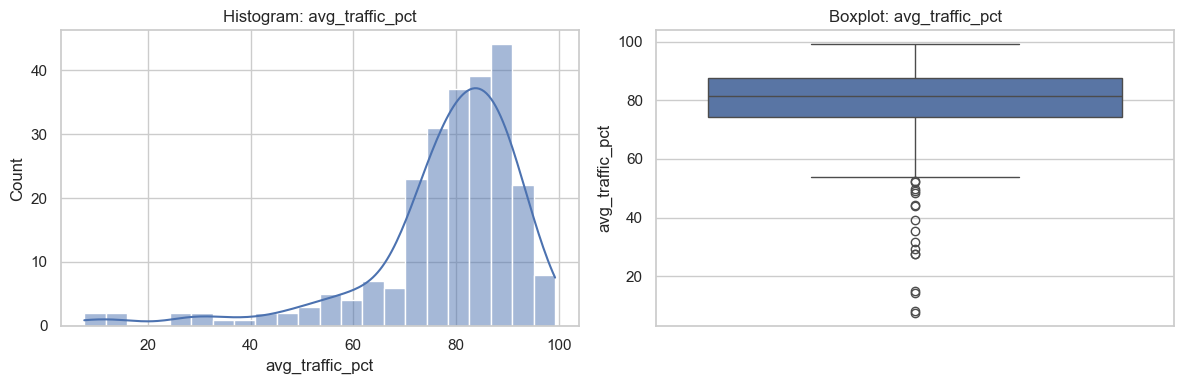

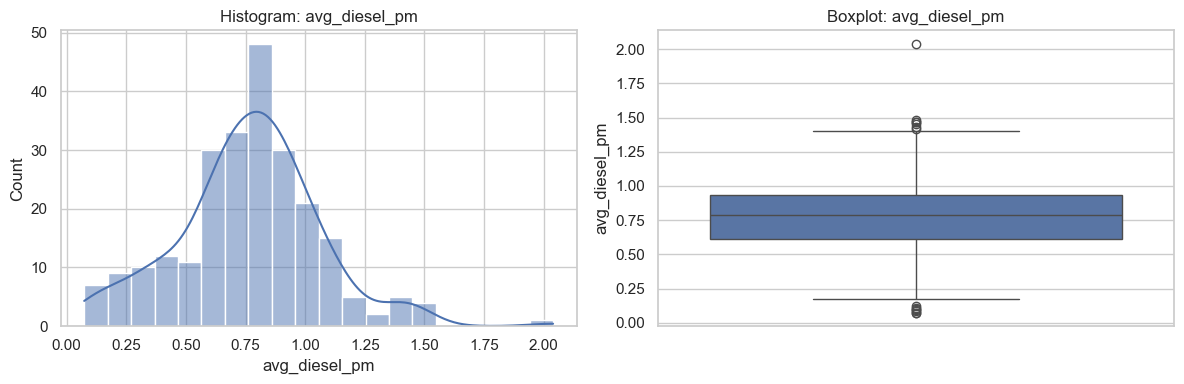

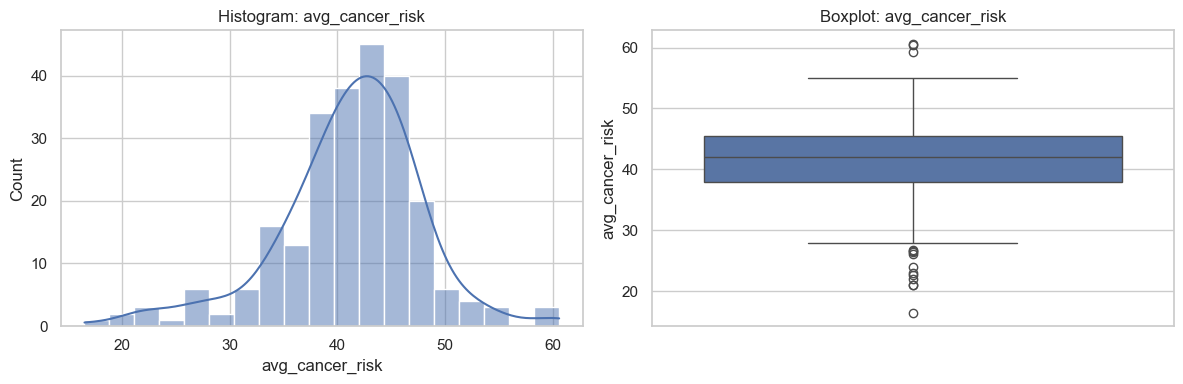

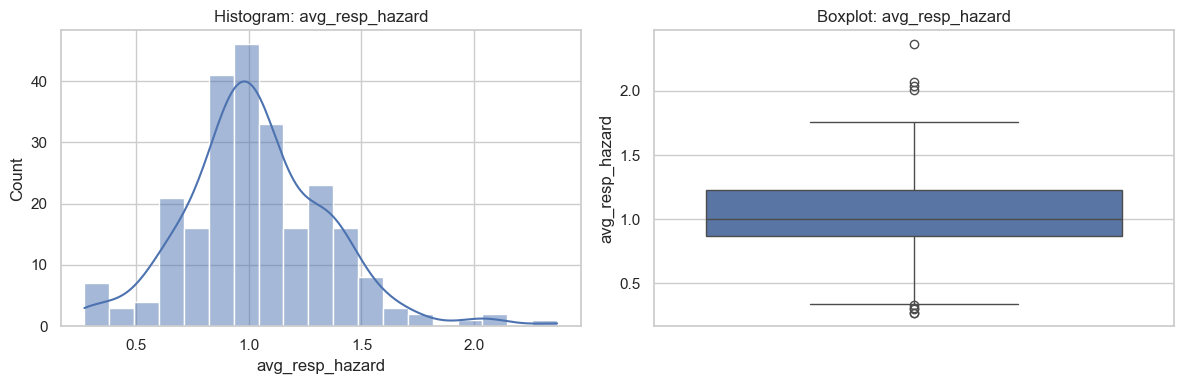

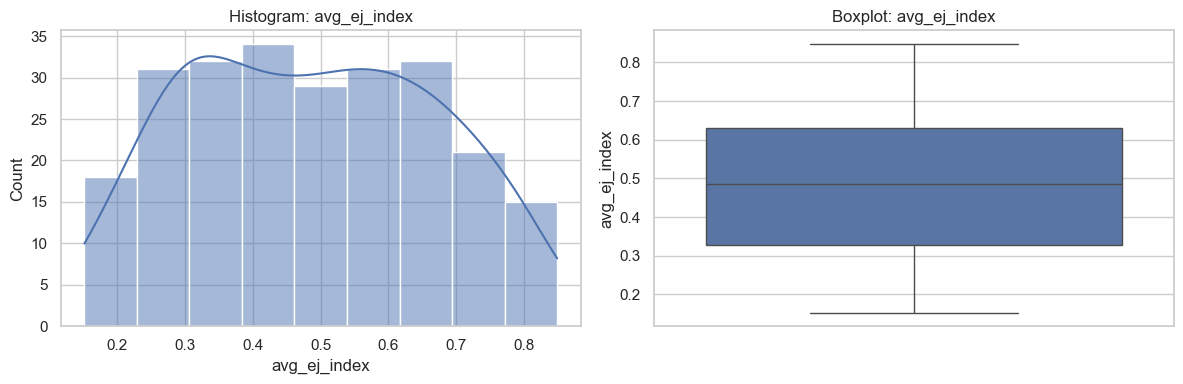

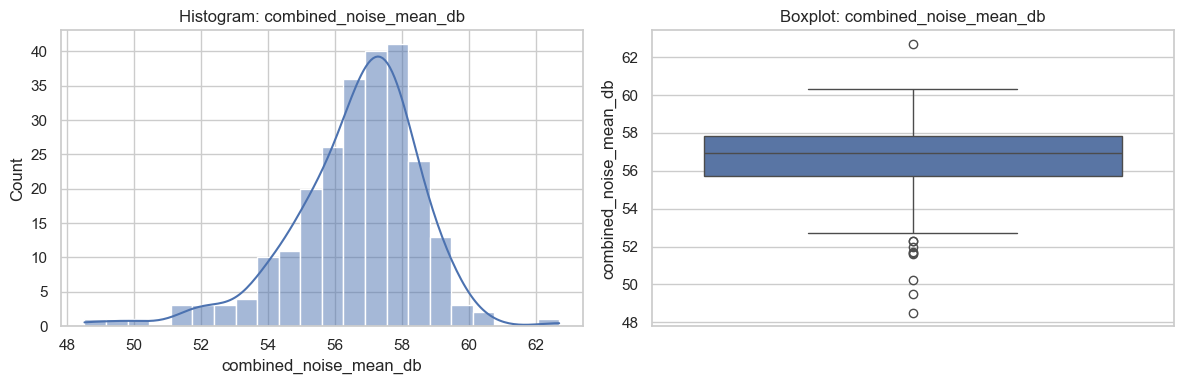

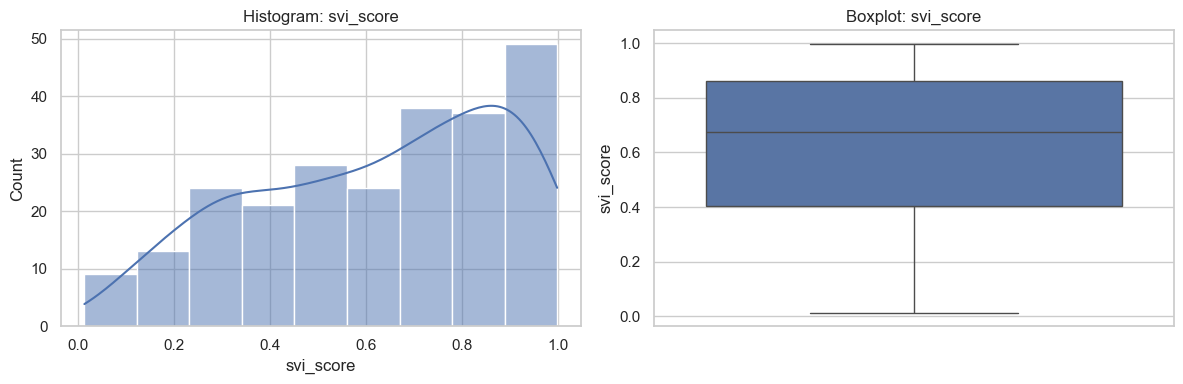

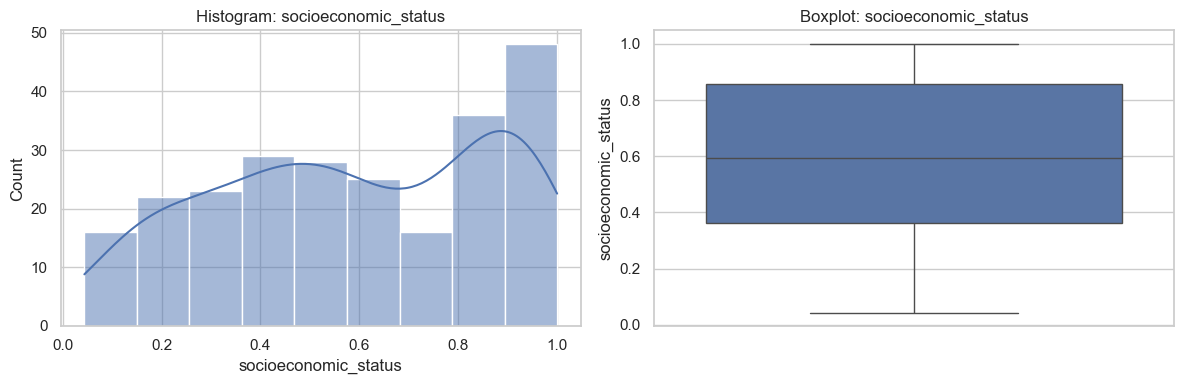

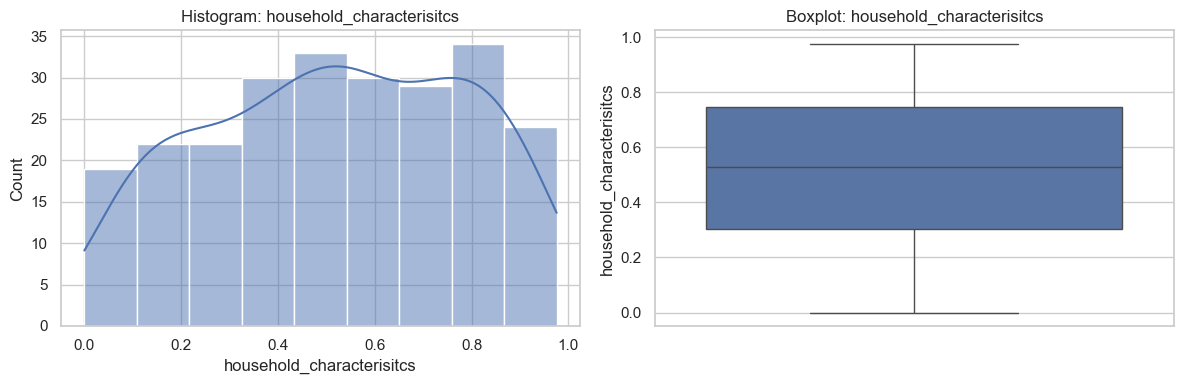

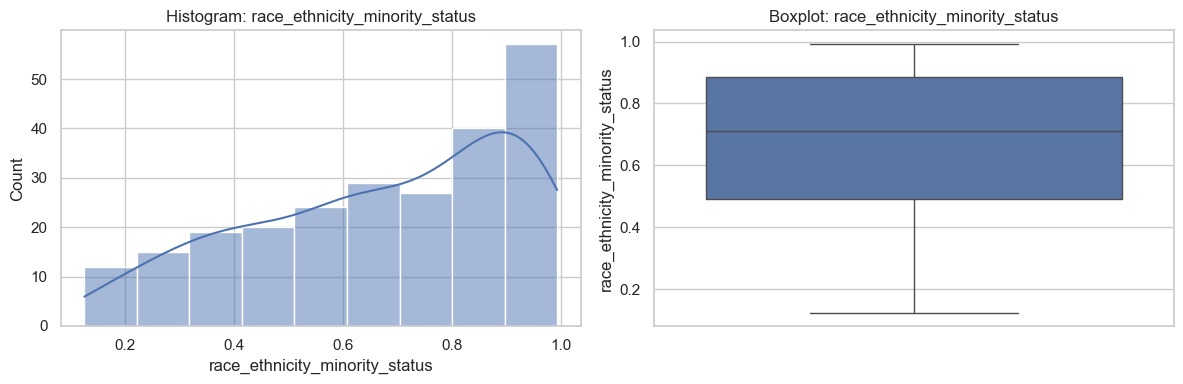

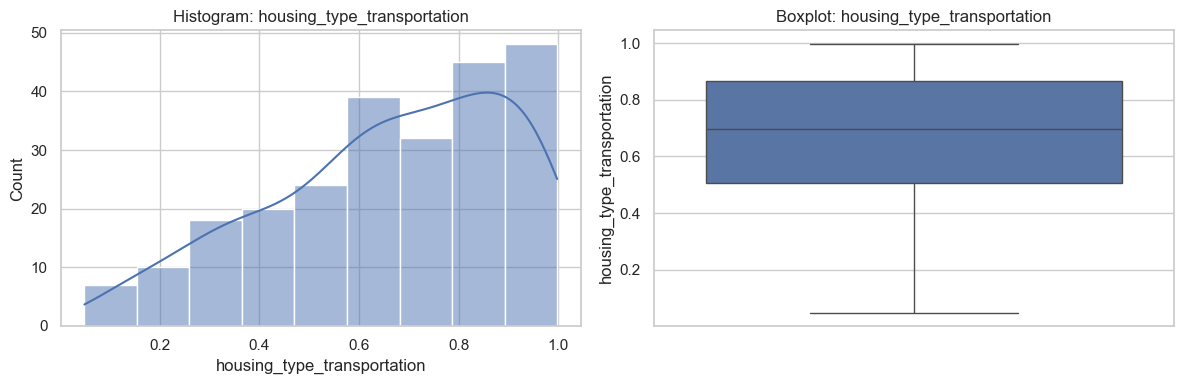

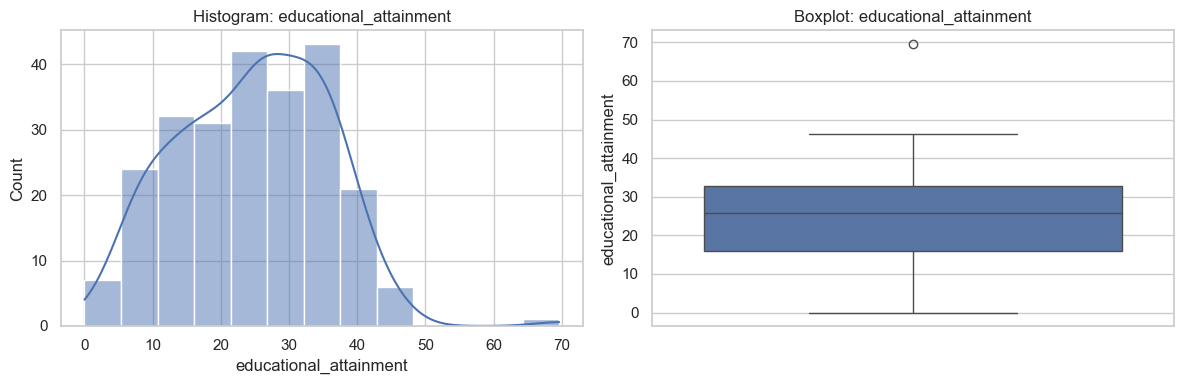

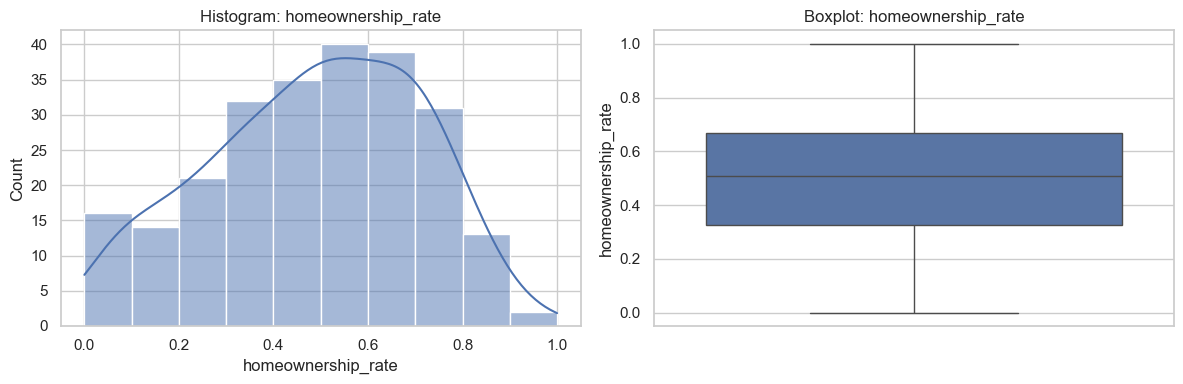

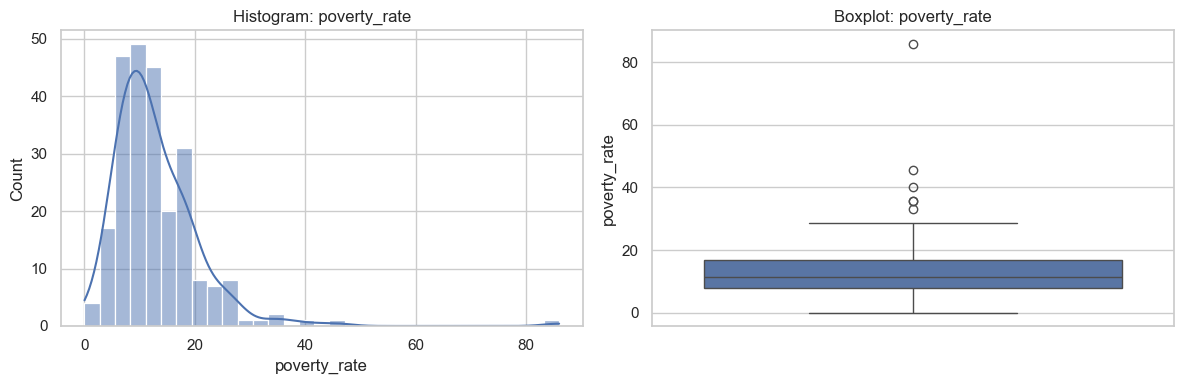

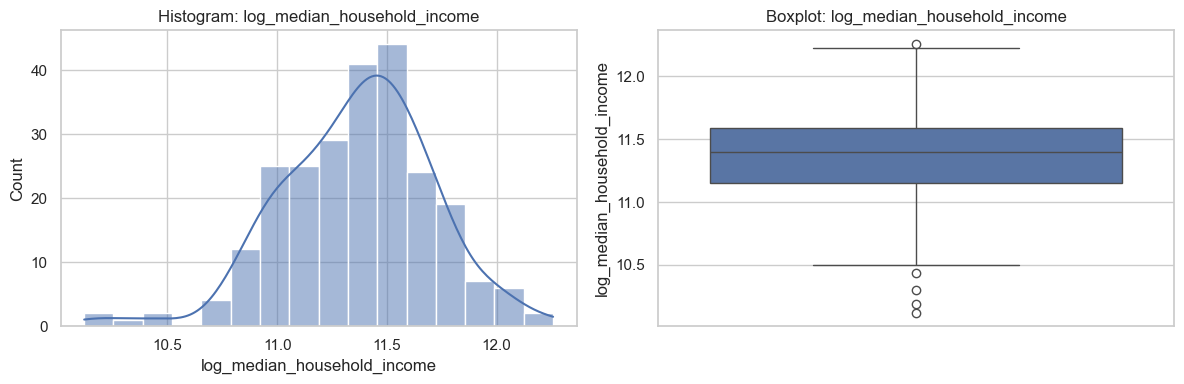

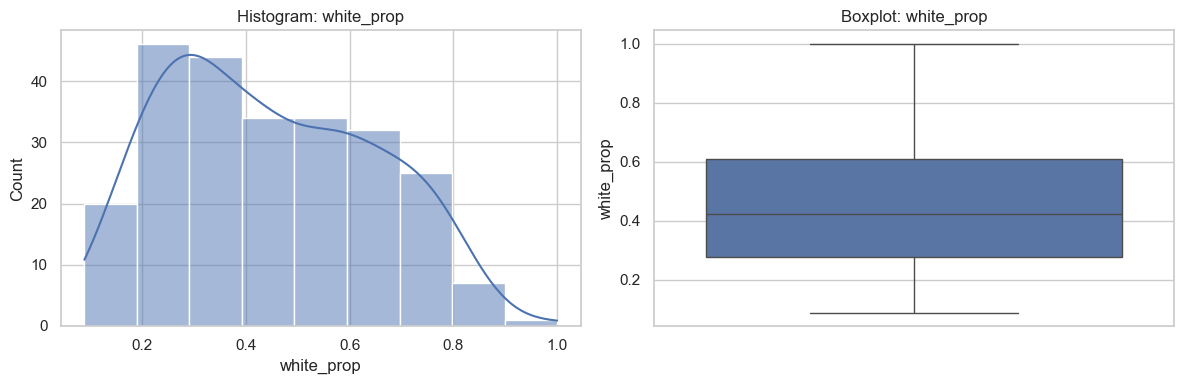

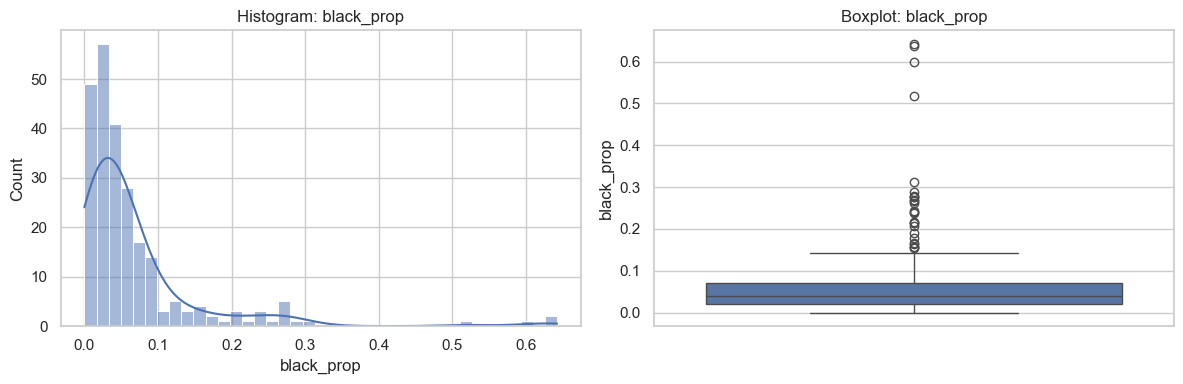

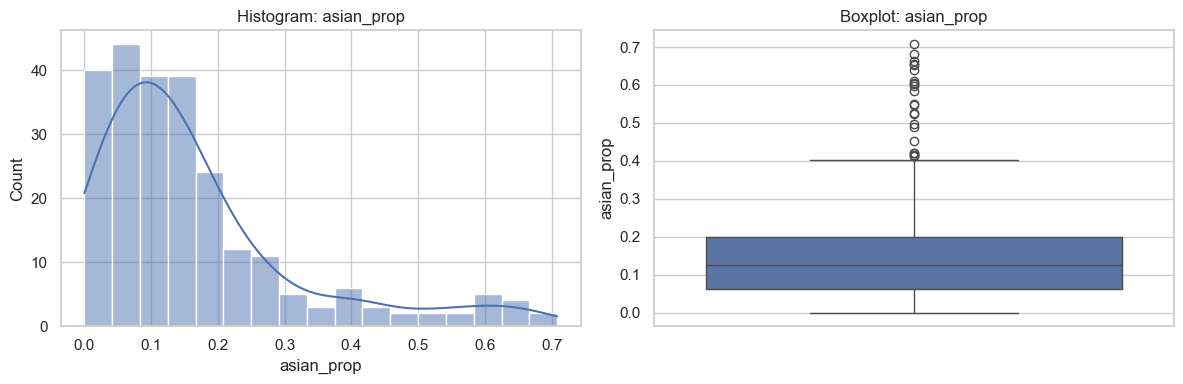

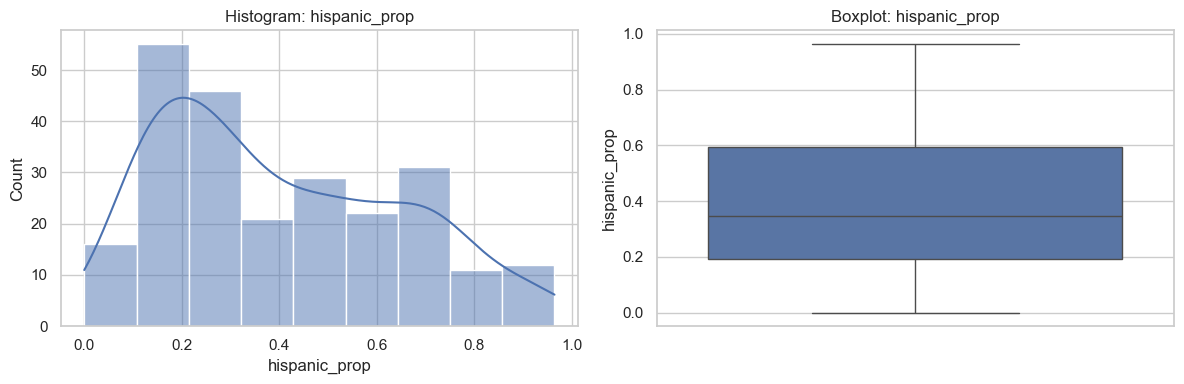

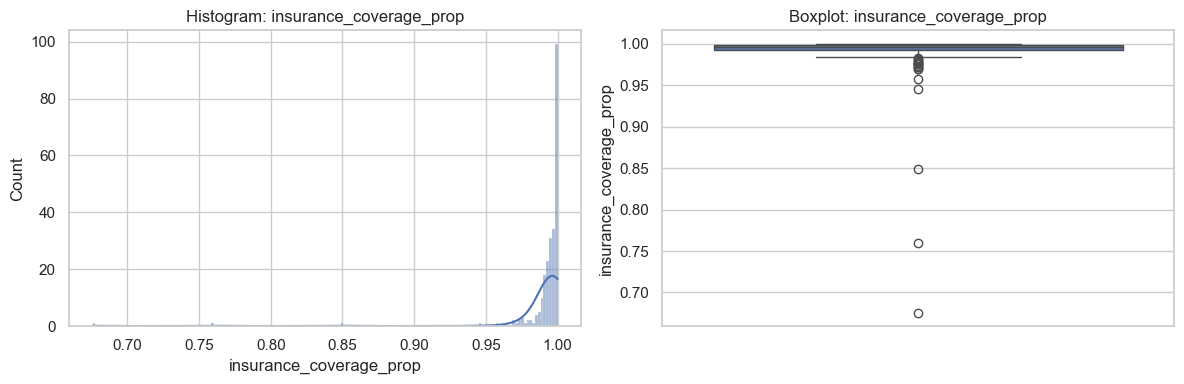

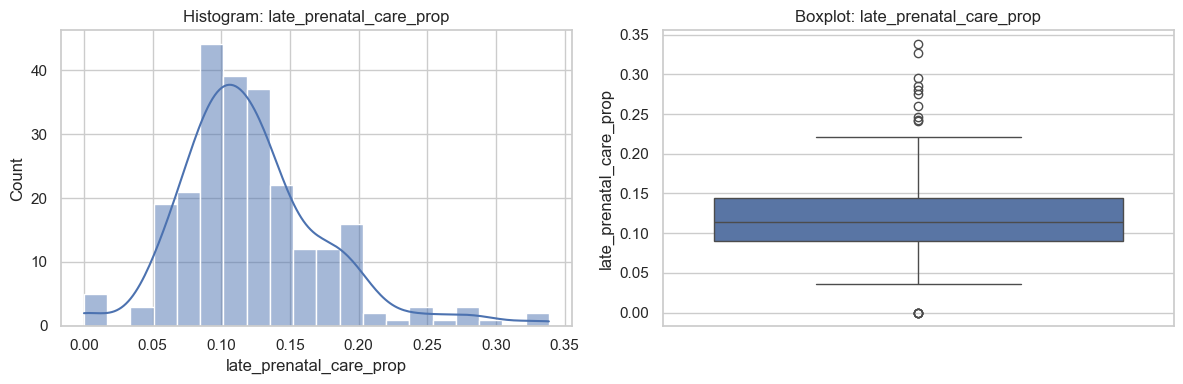

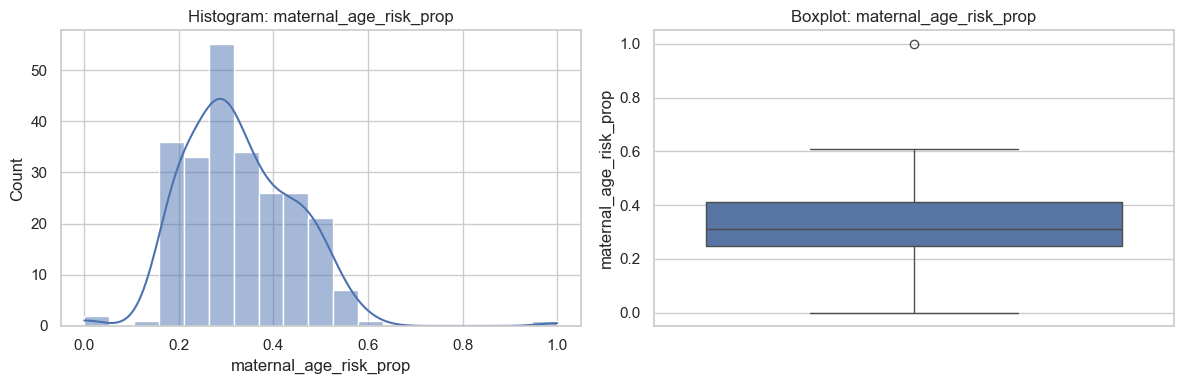

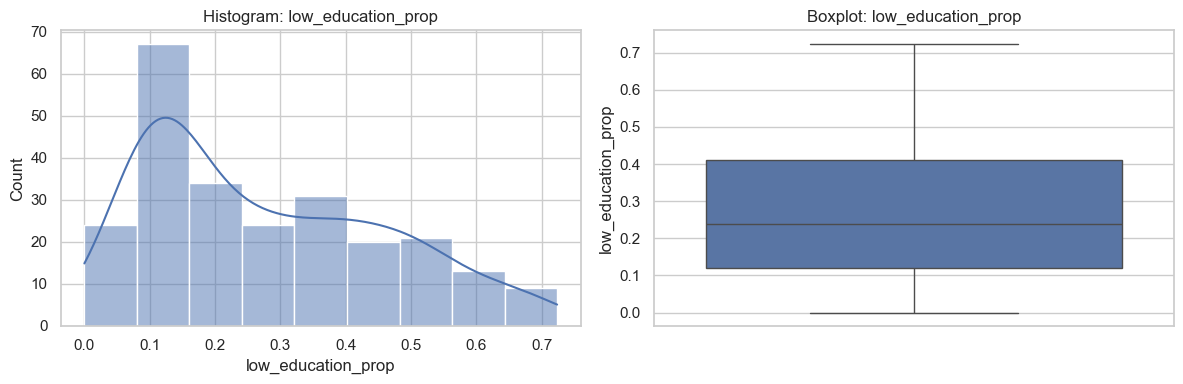

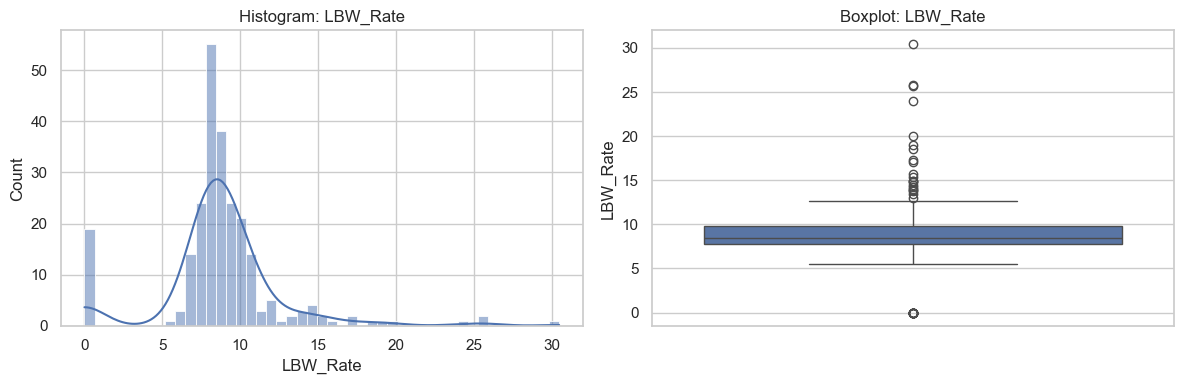

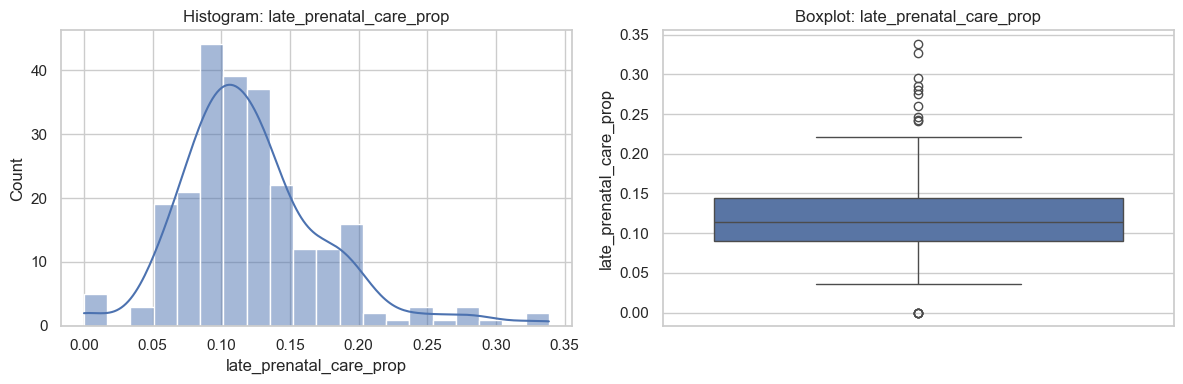

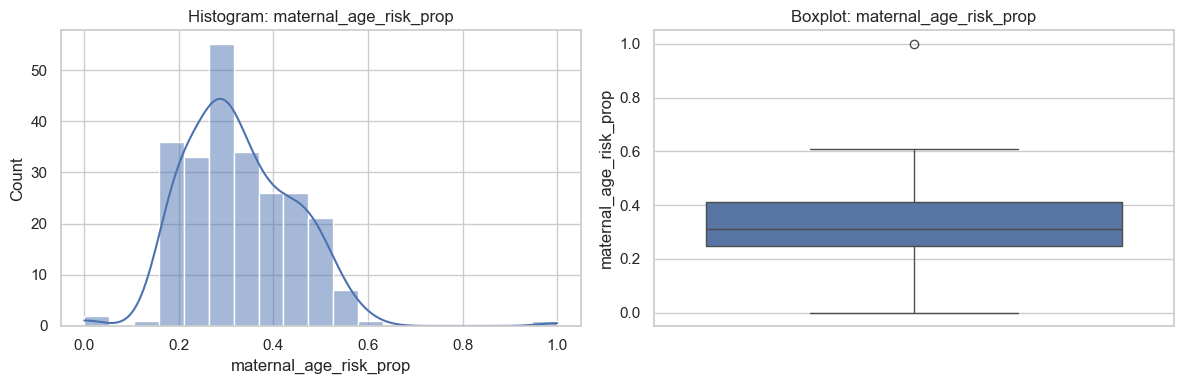

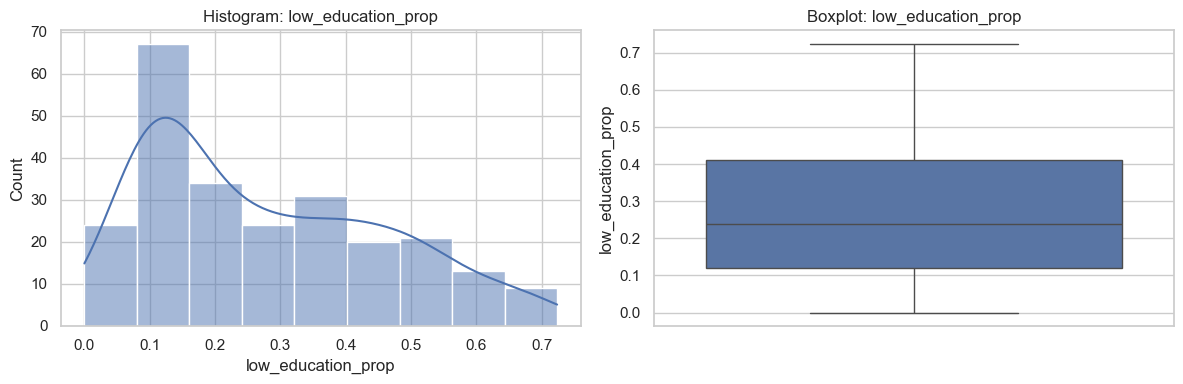

In [7]:
# Univariate EDA
univariate_summary = df[predictor_vars + [outcome_var] + maternal_props].describe().T
univariate_summary["IQR"] = univariate_summary["75%"] - univariate_summary["25%"]

univariate_summary

# creating distribution plots

sns.set(style="whitegrid")

for col in predictor_vars + [outcome_var] + maternal_props:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram: {col}")
    
    sns.boxplot(y=df[col], ax=axes[1])  # use y for numeric distribution
    axes[1].set_title(f"Boxplot: {col}")
    
    plt.tight_layout()
    plt.savefig(f"univariate_{col.replace('/', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


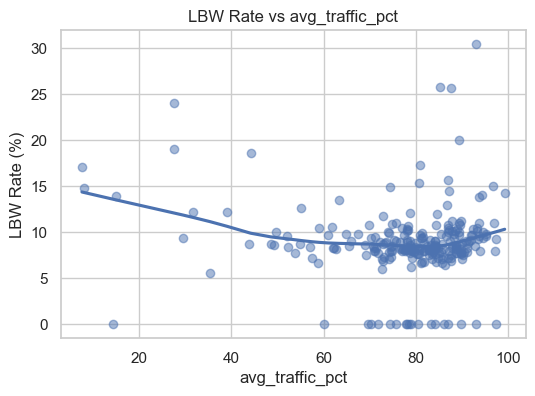

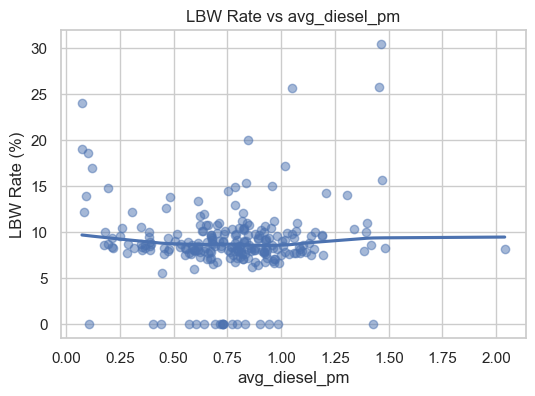

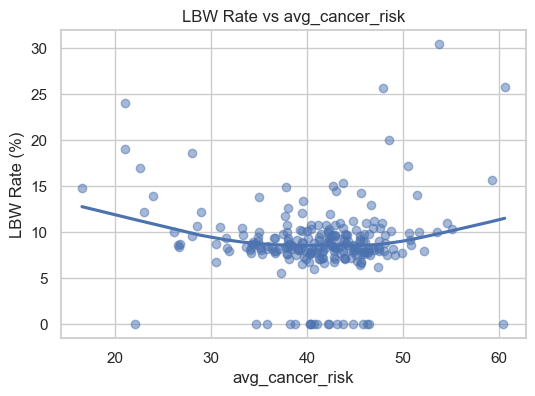

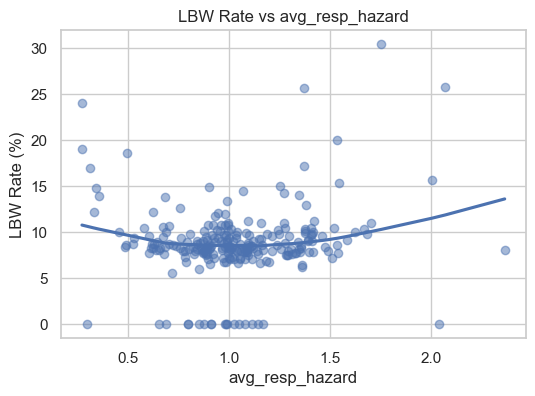

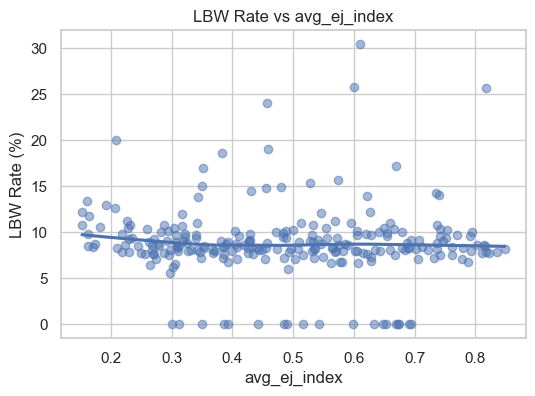

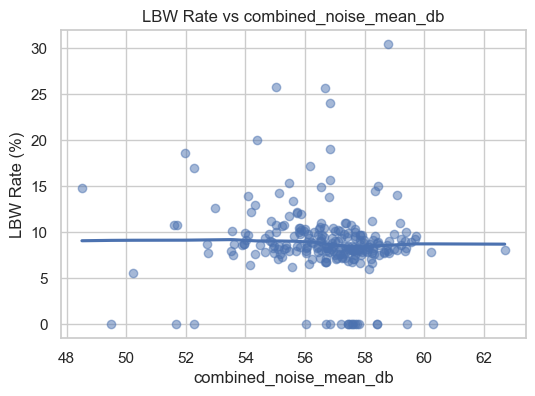

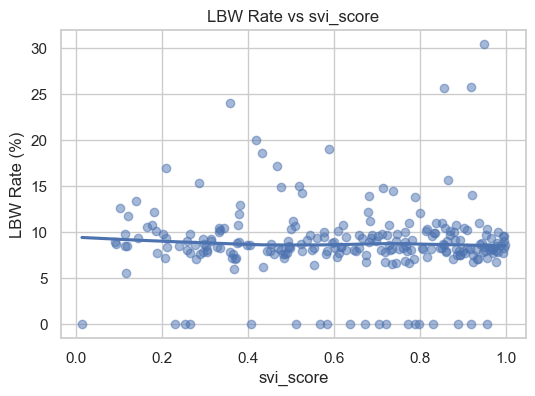

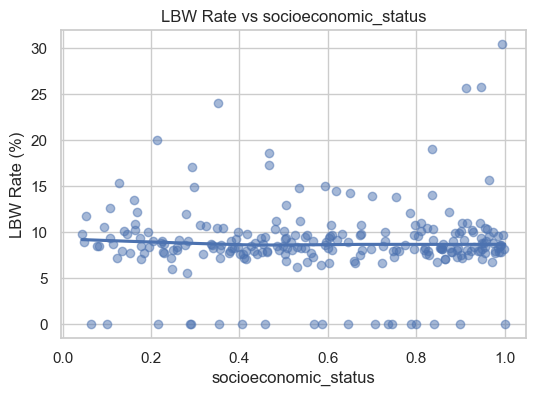

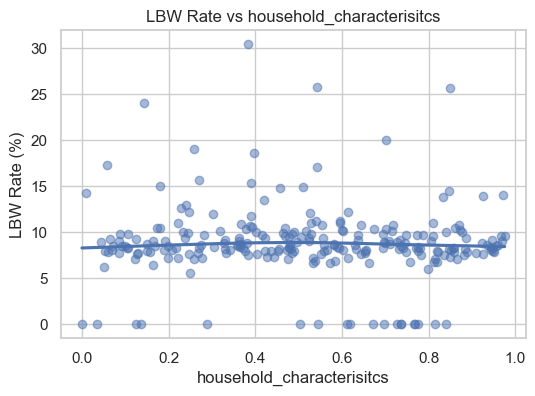

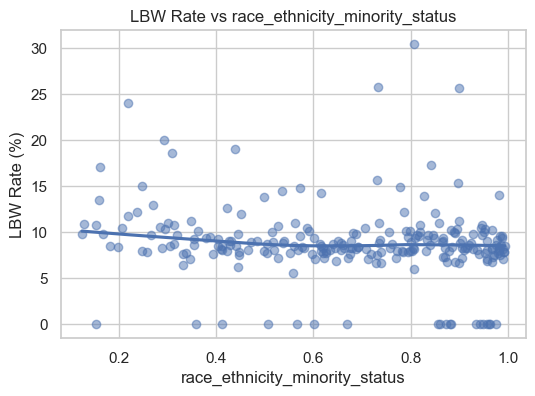

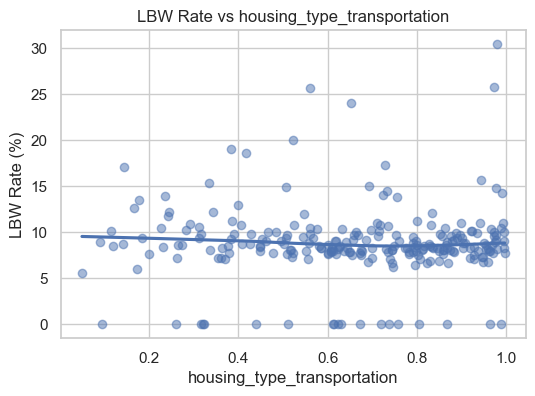

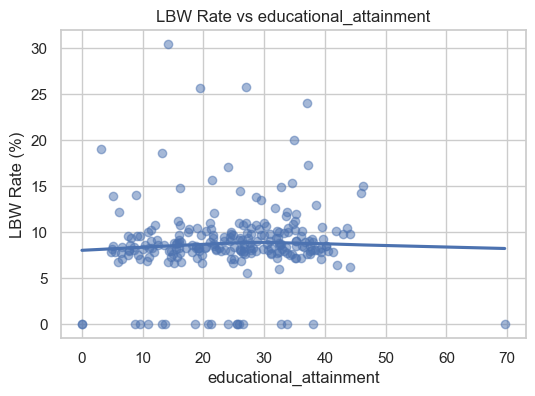

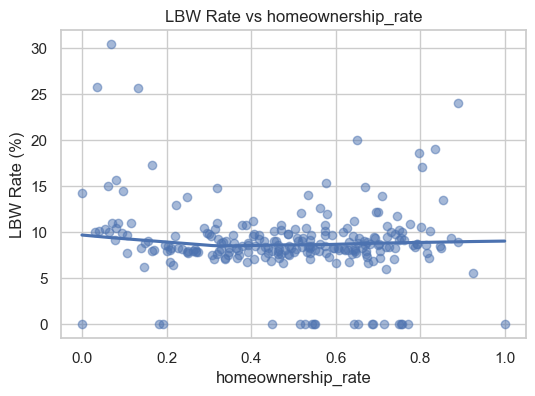

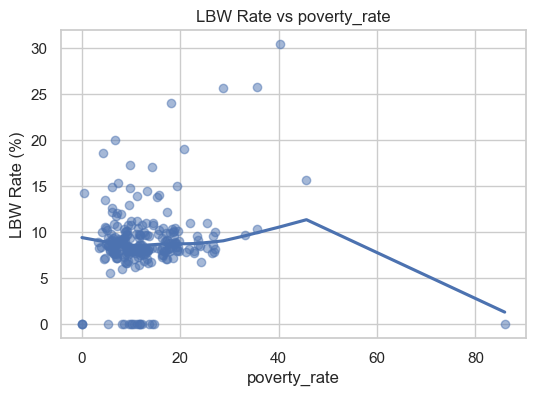

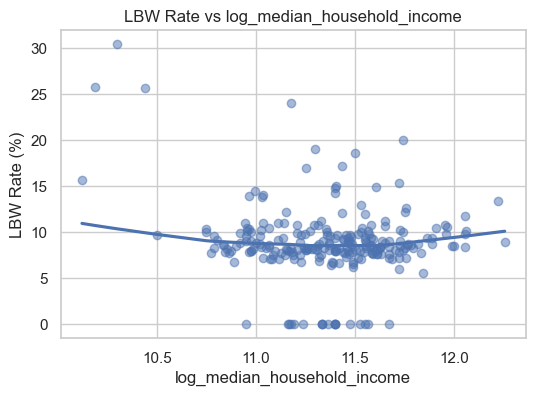

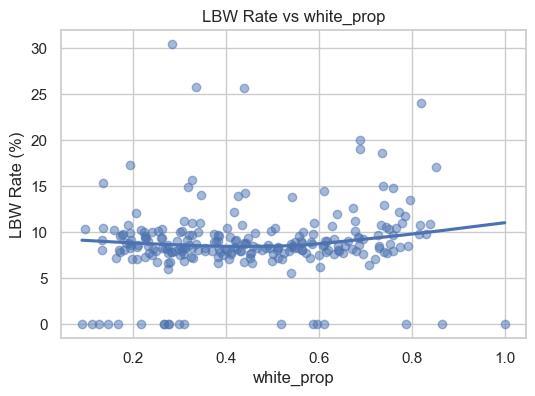

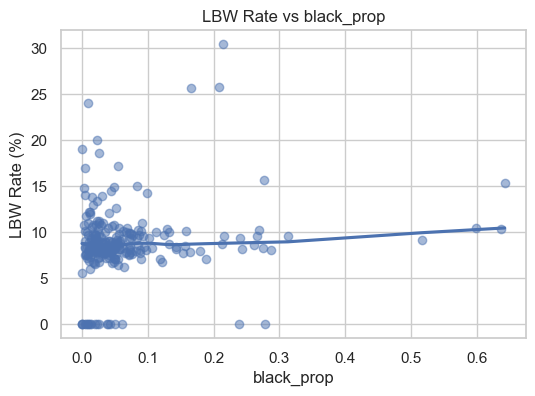

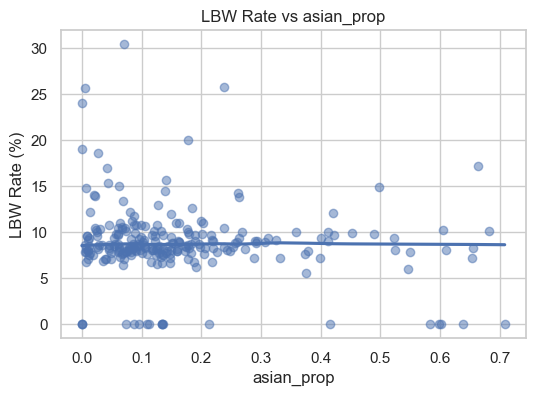

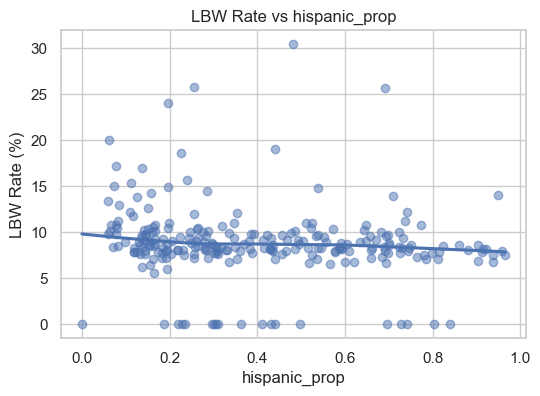

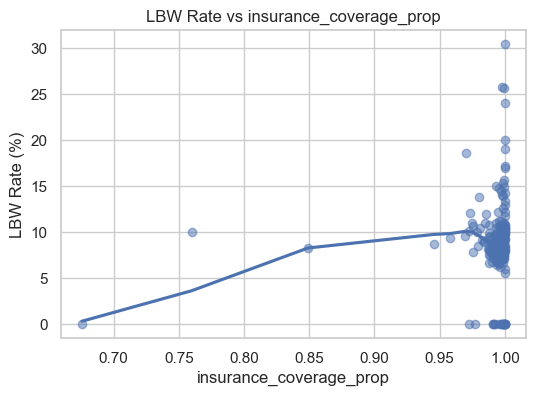

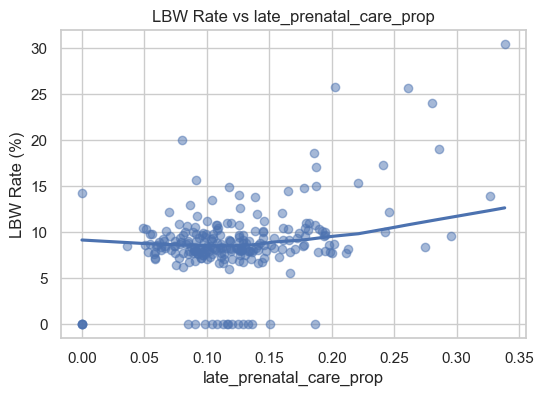

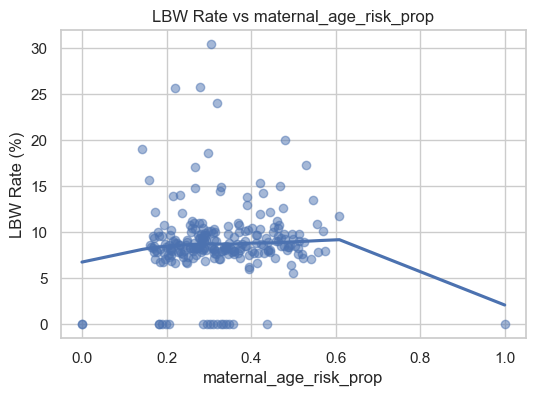

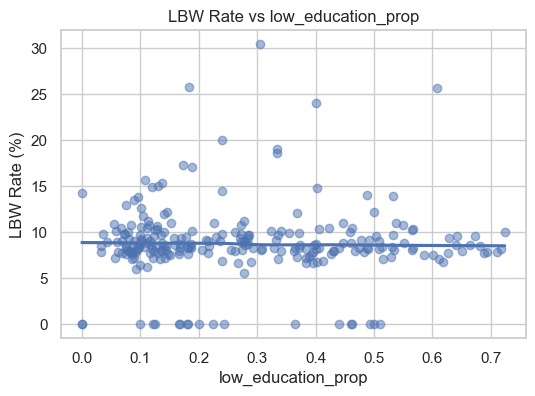

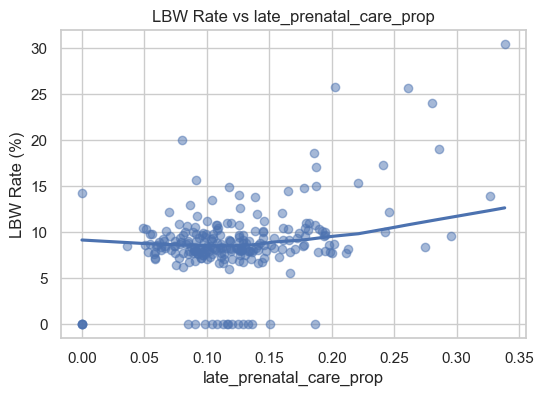

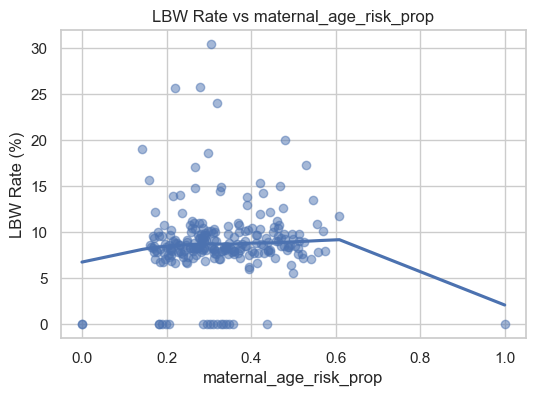

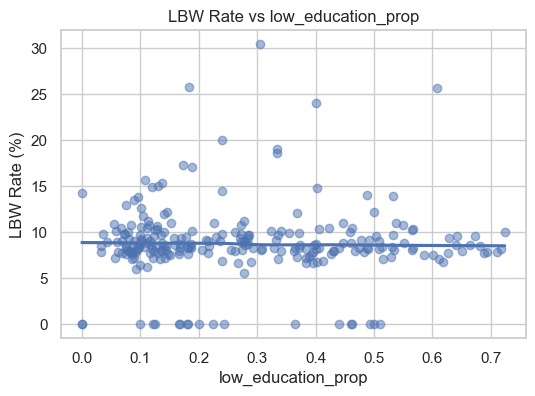

In [8]:
# Bivariate EDA
# Predictors vs LBW_Rate
for col in predictor_vars + maternal_props:
    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=df[col],
        y=df[outcome_var],
        lowess=True,
        scatter_kws={"alpha": 0.5}
    )
    
    plt.title(f"LBW Rate vs {col}")
    plt.xlabel(col)
    plt.ylabel("LBW Rate (%)")
    safe_col = col.replace("/", "_")
    plt.savefig(f"bivariate_{safe_col}_vs_{outcome_var}.png", dpi=300, bbox_inches="tight")
    
    plt.show()
    plt.close()


In [9]:
# Coorelation analysis
corr_results = []
for col in predictor_vars:
    pearson_r, pearson_p = pearsonr(df[col], df[outcome_var])
    spearman_r, spearman_p = spearmanr(df[col], df[outcome_var])
    
    corr_results.append({
        "feature": col,
        "pearson_r": pearson_r,
        "pearson_p": pearson_p,
        "spearman_r": spearman_r,
        "spearman_p": spearman_p})

corr_results = pd.DataFrame(corr_results)
corr_results.sort_values("pearson_p")

feature  pearson_r     pearson_p  spearman_r  \
20         late_prenatal_care_prop   0.423077  5.687813e-12    0.208056   
14     log_median_household_income  -0.178969  5.140621e-03   -0.019311   
9   race_ethnicity_minority_status  -0.171394  7.409889e-03   -0.199754   
13                    poverty_rate   0.161398  1.175166e-02    0.053715   
16                      black_prop   0.150944  1.855512e-02    0.098645   
12              homeownership_rate  -0.149042  2.010691e-02   -0.057425   
17                      asian_prop  -0.145239  2.354929e-02   -0.050699   
15                      white_prop   0.139626  2.955534e-02    0.148391   
18                   hispanic_prop  -0.136599  3.330554e-02   -0.235221   
5           combined_noise_mean_db  -0.120574  6.055578e-02   -0.201144   
19         insurance_coverage_prop   0.106214  9.856607e-02    0.134074   
3                  avg_resp_hazard   0.105350  1.013502e-01    0.052157   
0                  avg_traffic_pct  -0.103391  1.078978e-01    0.055839   
11          educational_attainment   0.068886  2.848179e-01    0.130365   
8        household_characterisitcs  -0.060878  3.446695e-01   -0.054409   
21          maternal_age_risk_prop   0.056932  3.768988e-01    0.108833   
4                     avg_ej_index  -0.046933  4.664644e-01   -0.105012   
7             socioeconomic_status   0.037508  5.606428e-01   -0.021361   
1                    avg_diesel_pm   0.034097  5.968560e-01   -0.019758   
2                  avg_cancer_risk  -0.016316  8.002277e-01   -0.018840   
10     housing_type_transportation   0.011367  8.600673e-01   -0.041798   
6                        svi_score  -0.008618  8.936735e-01   -0.062668   
22              low_education_prop  -0.002376  9.706103e-01   -0.058831   

    spearman_p  
20    0.001105  
14    0.764560  
9     0.001752  
13    0.404495  
16    0.125143  
12    0.372778  
17    0.431430  
15    0.020663  
18    0.000216  
5     0.001624  
19    0.036737  
3     0.418281  
0     0.386144  
11    0.042317  
8     0.398440  
21    0.090490  
4     0.102458  
7     0.740411  
1     0.759270  
2     0.770130  
10    0.516667  
6     0.330642  
22    0.361163

In [10]:
# Univariate regression
univariate_reg_results = []
for col in predictor_vars:
    X = sm.add_constant(df[col])
    y = df[outcome_var]
    
    model = sm.OLS(y, X).fit()
    
    univariate_reg_results.append({
        "feature": col,
        "coef": model.params[col],
        "p_value": model.pvalues[col],
        "r_squared": model.rsquared})

univariate_reg_results = pd.DataFrame(univariate_reg_results)
print(univariate_reg_results.sort_values("p_value"))

                           feature       coef       p_value  r_squared
20         late_prenatal_care_prop  32.016820  5.687813e-12   0.178994
14     log_median_household_income  -2.111516  5.140621e-03   0.032030
9   race_ethnicity_minority_status  -2.839386  7.409889e-03   0.029376
13                    poverty_rate   0.078098  1.175166e-02   0.026049
16                      black_prop   6.521878  1.855512e-02   0.022784
12              homeownership_rate  -2.697107  2.010691e-02   0.022213
17                      asian_prop  -3.800802  2.354929e-02   0.021094
15                      white_prop   2.798369  2.955534e-02   0.019495
18                   hispanic_prop  -2.239911  3.330554e-02   0.018659
5           combined_noise_mean_db  -0.256899  6.055578e-02   0.014538
19         insurance_coverage_prop  15.319430  9.856607e-02   0.011281
3                  avg_resp_hazard   1.333494  1.013502e-01   0.011099
0                  avg_traffic_pct  -0.026813  1.078978e-01   0.010690
11    

In [11]:
# full regression to determine multicollinearity
X_full = sm.add_constant(df[predictor_vars])
y = df[outcome_var]
full_model = sm.OLS(y, X_full).fit()

print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:               LBW_Rate   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     7.545
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           1.42e-17
Time:                        02:35:18   Log-Likelihood:                -611.91
No. Observations:                 243   AIC:                             1272.
Df Residuals:                     219   BIC:                             1356.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

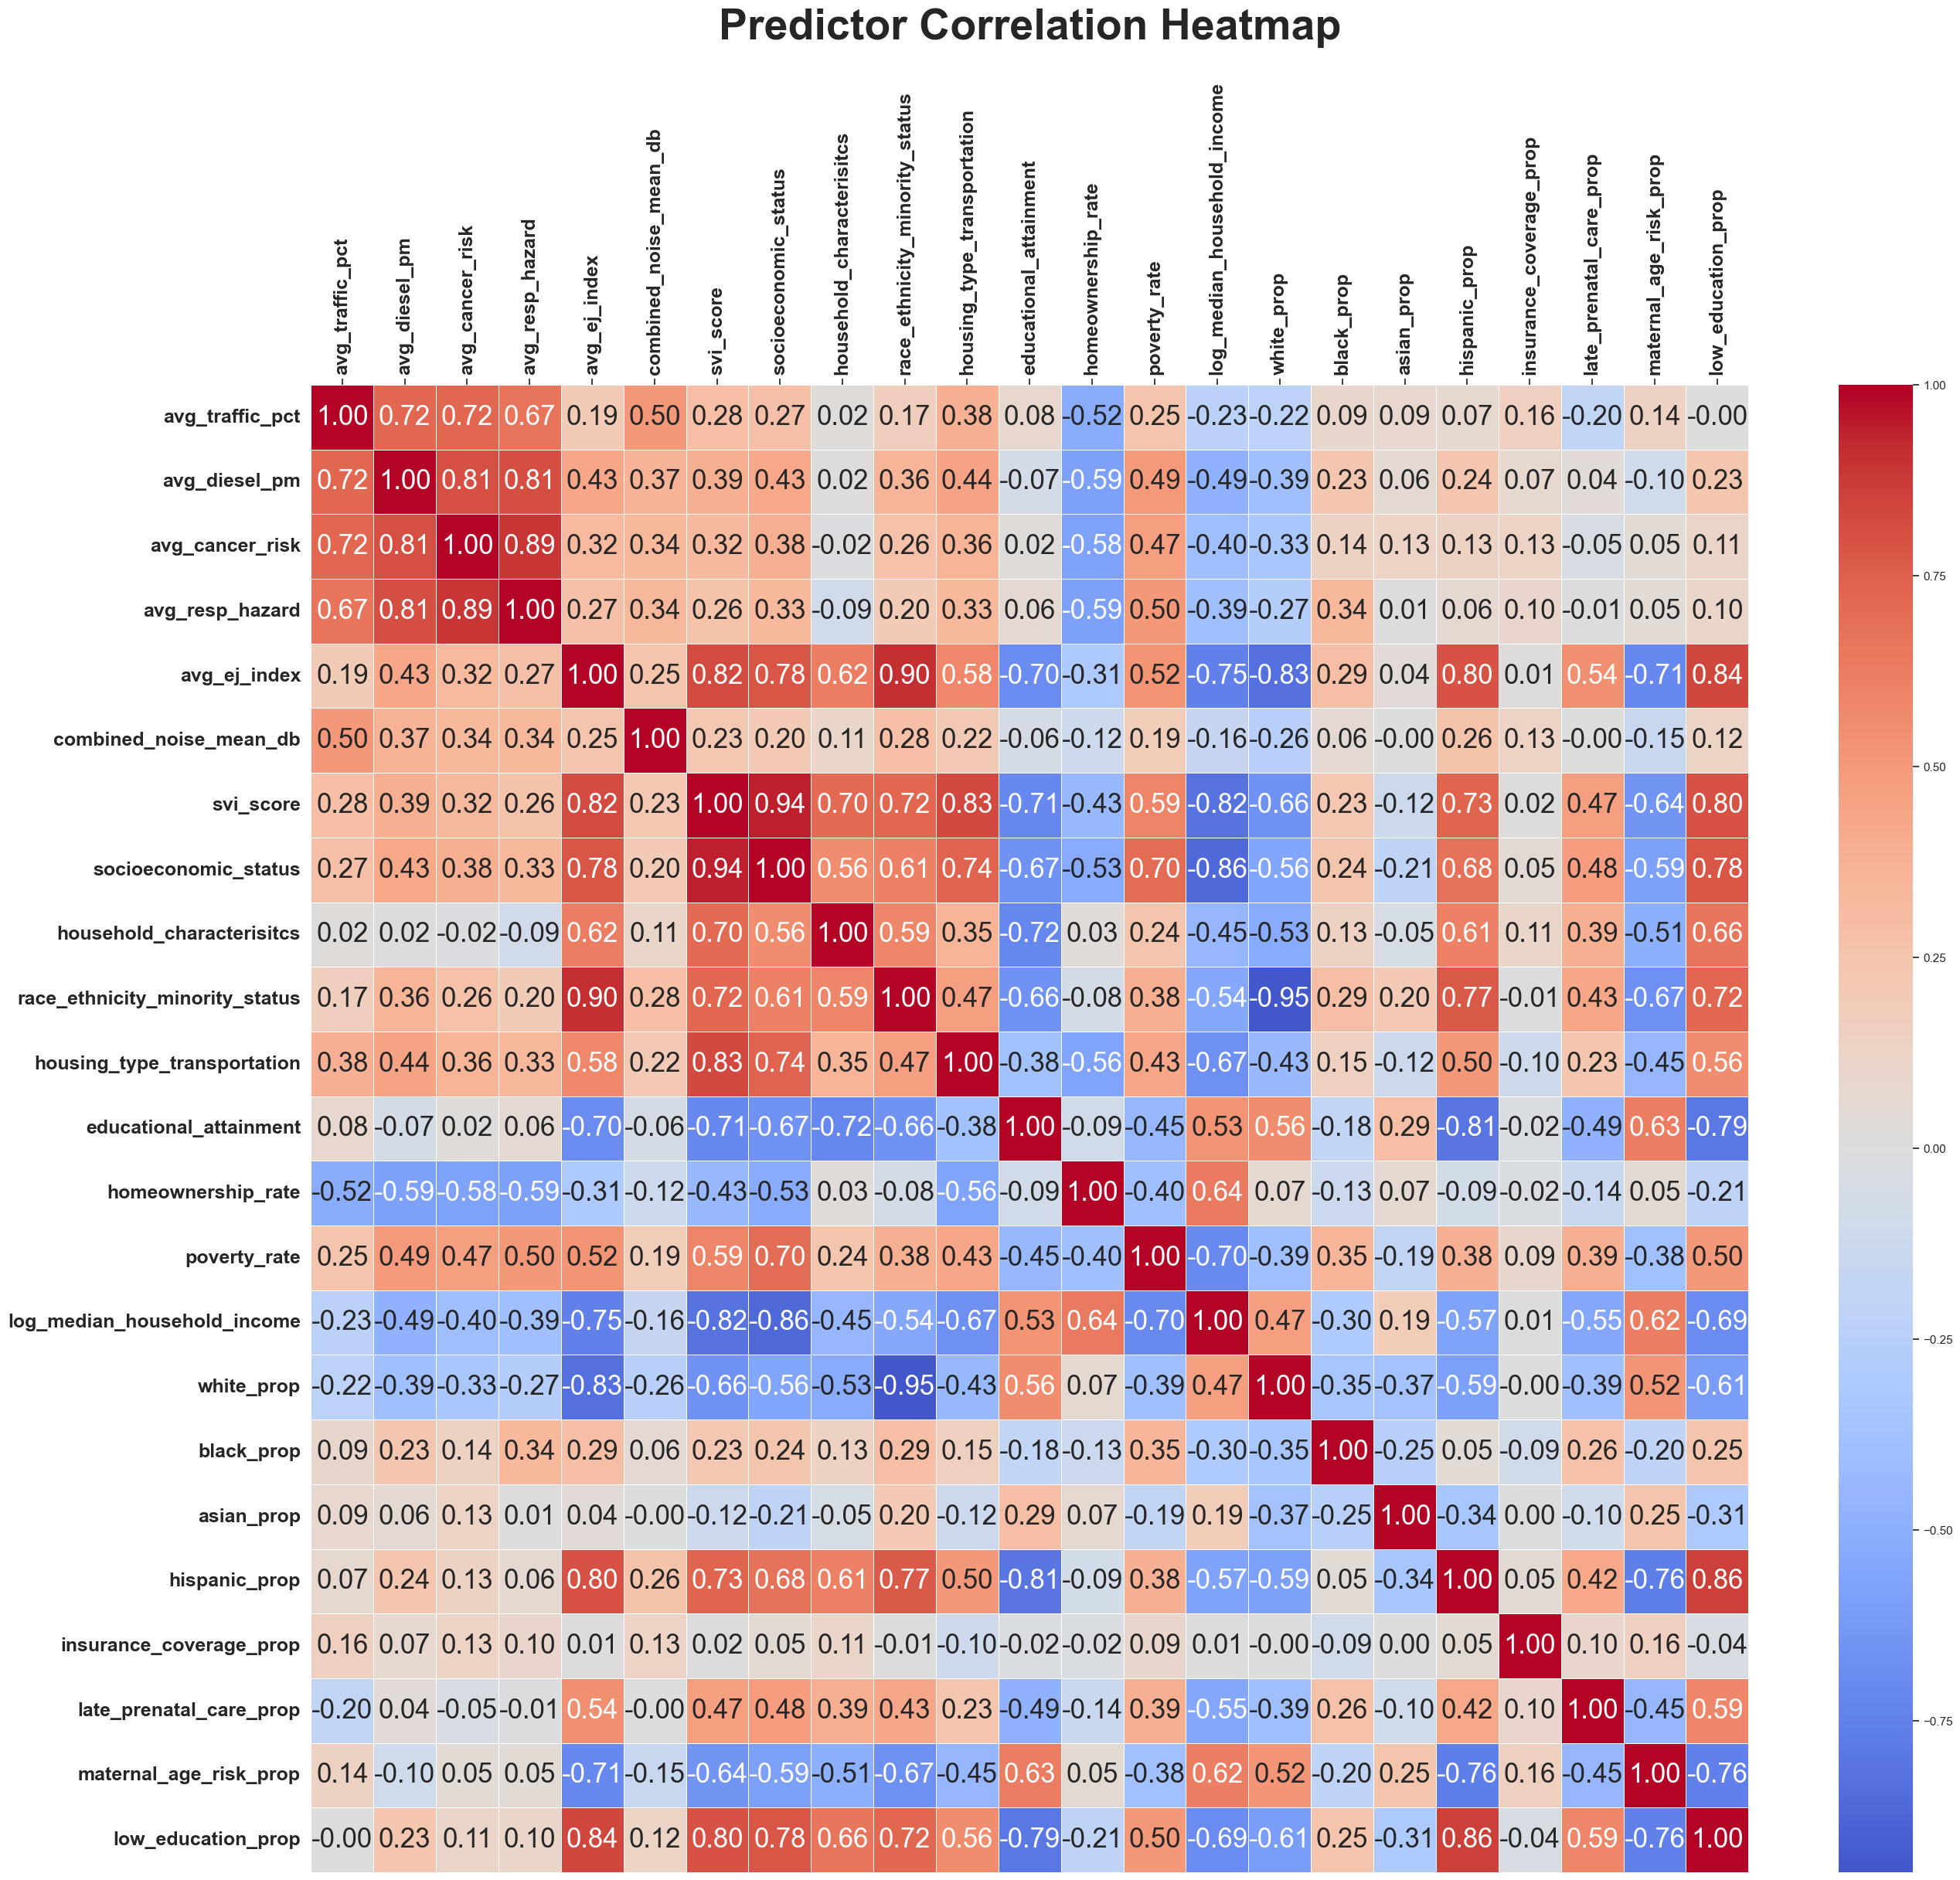

avg_traffic_pct  avg_diesel_pm  \
avg_traffic_pct                        1.000000       0.683913   
avg_diesel_pm                          0.683913       1.000000   
avg_cancer_risk                        0.570501       0.773285   
avg_resp_hazard                        0.636035       0.843052   
avg_ej_index                           0.181395       0.457088   
combined_noise_mean_db                 0.402084       0.301743   
svi_score                              0.245565       0.405949   
socioeconomic_status                   0.291669       0.455440   
household_characterisitcs             -0.047887       0.022760   
race_ethnicity_minority_status         0.101345       0.410710   
housing_type_transportation            0.327490       0.426312   
educational_attainment                 0.073453      -0.095727   
homeownership_rate                    -0.579314      -0.587507   
poverty_rate                           0.313074       0.446056   
log_median_household_income           -0.282103      -0.458998   
white_prop                            -0.114087      -0.411401   
black_prop                             0.235024       0.275266   
asian_prop                             0.047548       0.005110   
hispanic_prop                          0.046986       0.242331   
insurance_coverage_prop               -0.103373      -0.018883   
late_prenatal_care_prop                0.009777       0.192027   
maternal_age_risk_prop                 0.072097      -0.141607   
low_education_prop                     0.018817       0.232419   

                                avg_cancer_risk  avg_resp_hazard  \
avg_traffic_pct                        0.570501         0.636035   
avg_diesel_pm                          0.773285         0.843052   
avg_cancer_risk                        1.000000         0.918925   
avg_resp_hazard                        0.918925         1.000000   
avg_ej_index                           0.345727         0.303774   
combined_noise_mean_db                 0.232274         0.253060   
svi_score                              0.347010         0.309345   
socioeconomic_status                   0.437704         0.397868   
household_characterisitcs             -0.019104        -0.062321   
race_ethnicity_minority_status         0.280574         0.240206   
housing_type_transportation            0.355806         0.343601   
educational_attainment                 0.004863         0.054370   
homeownership_rate                    -0.636743        -0.655806   
poverty_rate                           0.464670         0.449812   
log_median_household_income           -0.427395        -0.397184   
white_prop                            -0.292848        -0.261923   
black_prop                             0.072735         0.233125   
asian_prop                             0.059436        -0.047444   
hispanic_prop                          0.134524         0.068961   
insurance_coverage_prop                0.031352         0.063172   
late_prenatal_care_prop                0.162481         0.114794   
maternal_age_risk_prop                 0.003279         0.027572   
low_education_prop                     0.140919         0.108331   

                                avg_ej_index  combined_noise_mean_db  \
avg_traffic_pct                     0.181395                0.402084   
avg_diesel_pm                       0.457088                0.301743   
avg_cancer_risk                     0.345727                0.232274   
avg_resp_hazard                     0.303774                0.253060   
avg_ej_index                        1.000000                0.253180   
combined_noise_mean_db              0.253180                1.000000   
svi_score                           0.841979                0.230388   
socioeconomic_status                0.786935                0.203879   
household_characterisitcs           0.630368                0.124365   
race_ethnicity_minority_status      0.922964                0.279427   
housing_type_transport

In [12]:
# Predictor correlation heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(
    df[predictor_vars].corr(),
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 25})
plt.title("Predictor Correlation Heatmap",fontsize=40, fontweight="bold", loc="center",pad=40)
plt.tick_params(axis="x", top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(rotation=90, ha="center", fontsize=18, fontweight="bold")
plt.yticks(rotation=0, fontsize=18, fontweight="bold")
plt.savefig("predictor_correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()
# results in table format
corr_table = df[predictor_vars].corr(method="spearman")
corr_table

In [13]:
# Variance Inflation Factor
X_vif = sm.add_constant(df[predictor_vars])
vif_table = pd.DataFrame({"feature": X_vif.columns,
    "VIF": [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_vif.shape[1])]
})
vif_table = vif_table[vif_table["feature"] != "const"]
vif_table.sort_values("VIF", ascending=False)

feature         VIF
19                   hispanic_prop  206.933177
10  race_ethnicity_minority_status  197.045009
7                        svi_score  148.483938
18                      asian_prop   77.376317
8             socioeconomic_status   50.703062
16                      white_prop   33.134310
17                      black_prop   32.579339
11     housing_type_transportation   19.082552
5                     avg_ej_index   18.376598
9        household_characterisitcs   11.781173
23              low_education_prop   11.273538
15     log_median_household_income   10.690292
3                  avg_cancer_risk    9.003365
4                  avg_resp_hazard    8.707657
12          educational_attainment    7.693456
13              homeownership_rate    6.413678
22          maternal_age_risk_prop    5.073027
2                    avg_diesel_pm    4.859909
1                  avg_traffic_pct    4.524000
14                    poverty_rate    3.643888
21         late_prenatal_care_prop    2.478161
6           combined_noise_mean_db    1.771272
20         insurance_coverage_prop    1.439804

In [14]:
# Decision table

decision_table = (corr_results.merge(univariate_reg_results, on="feature").merge(vif_table, on="feature"))

decision_table["cluster"] = ""
decision_table["decision"] = ""

# Cluster assignment based on heatmap |r| ≥ 0.7

cluster_map = {
    # Cluster A: Air / traffic pollution 
    "avg_traffic_pct": "cluster_air_pollution",
    "avg_diesel_pm": "cluster_air_pollution",
    "avg_cancer_risk": "cluster_air_pollution",
    "avg_resp_hazard": "cluster_air_pollution",

    # Cluster B: Social vulnerability / EJ 
    "avg_ej_index": "cluster_social_ej",
    "svi_score": "cluster_social_ej",
    "socioeconomic_status": "cluster_social_ej",
    "household_characteristics": "cluster_social_ej",
    "race_ethnicity_minority_status": "cluster_social_ej",
    "housing_type_transportation": "cluster_social_ej",

    # Cluster C: SES core
    "log_median_household_income": "cluster_ses_core",
    "poverty_rate": "cluster_ses_core",
    "educational_attainment": "cluster_ses_core",
    "homeownership_rate": "cluster_ses_core",

    # Cluster D: Race / ethnicity
    "white_prop": "cluster_race",
    "black_prop": "cluster_race",
    "asian_prop": "cluster_race",
    "hispanic_prop": "cluster_race",

    # Cluster E: Maternal risk
    "low_education_prop": "cluster_maternal",
    "late_prenatal_care_prop": "cluster_maternal",
    "maternal_age_risk_prop": "cluster_maternal",
}

decision_table["cluster"] = decision_table["feature"].map(cluster_map).fillna("solo")

# Rule 1: Drop for no outcome signal except maternal cluster if both pearson and spearman p-values are greater than and equal to 0.10

rule1_mask = ((decision_table["pearson_p"] > 0.10) &(decision_table["spearman_p"] > 0.10) &(decision_table["cluster"] != "cluster_maternal"))
decision_table.loc[rule1_mask, "decision"] = "Drop"

for cluster_name in decision_table["cluster"].unique():

    if cluster_name in ["solo", "cluster_maternal"]:
        continue

    cluster_df = decision_table.query("cluster == @cluster_name")

    # Exclude already decided features
    cluster_df = cluster_df[cluster_df["decision"] == ""]

    if cluster_df.empty:
        continue

    # Keep strongest univariate signal
    keep_feature = cluster_df.sort_values("p_value").iloc[0]["feature"]
    decision_table.loc[decision_table["feature"] == keep_feature, "decision"] = "Keep"

    redundant_features = cluster_df[cluster_df["feature"] != keep_feature]["feature"]

    for feat in redundant_features:
        vif_value = decision_table.loc[
            decision_table["feature"] == feat, "VIF"
        ].iloc[0]

        # PCA only allowed for social EJ cluster
        if cluster_name == "cluster_social_ej" and vif_value >= 10:
            decision_table.loc[
                decision_table["feature"] == feat, "decision"
            ] = "Merge_pca"
        else:
            decision_table.loc[
                decision_table["feature"] == feat, "decision"
            ] = "Drop"

# Maternal cluster: keeping

decision_table.loc[
    decision_table["cluster"] == "cluster_maternal", "decision"] = "Keep"

# Solo features: also keep by default

solo_mask = ((decision_table["cluster"] == "solo") & (decision_table["decision"] == ""))

decision_table.loc[solo_mask, "decision"] = "Keep"

decision_table


feature  pearson_r     pearson_p  spearman_r  \
0                  avg_traffic_pct  -0.103391  1.078978e-01    0.055839   
1                    avg_diesel_pm   0.034097  5.968560e-01   -0.019758   
2                  avg_cancer_risk  -0.016316  8.002277e-01   -0.018840   
3                  avg_resp_hazard   0.105350  1.013502e-01    0.052157   
4                     avg_ej_index  -0.046933  4.664644e-01   -0.105012   
5           combined_noise_mean_db  -0.120574  6.055578e-02   -0.201144   
6                        svi_score  -0.008618  8.936735e-01   -0.062668   
7             socioeconomic_status   0.037508  5.606428e-01   -0.021361   
8        household_characterisitcs  -0.060878  3.446695e-01   -0.054409   
9   race_ethnicity_minority_status  -0.171394  7.409889e-03   -0.199754   
10     housing_type_transportation   0.011367  8.600673e-01   -0.041798   
11          educational_attainment   0.068886  2.848179e-01    0.130365   
12              homeownership_rate  -0.149042  2.010691e-02   -0.057425   
13                    poverty_rate   0.161398  1.175166e-02    0.053715   
14     log_median_household_income  -0.178969  5.140621e-03   -0.019311   
15                      white_prop   0.139626  2.955534e-02    0.148391   
16                      black_prop   0.150944  1.855512e-02    0.098645   
17                      asian_prop  -0.145239  2.354929e-02   -0.050699   
18                   hispanic_prop  -0.136599  3.330554e-02   -0.235221   
19         insurance_coverage_prop   0.106214  9.856607e-02    0.134074   
20         late_prenatal_care_prop   0.423077  5.687813e-12    0.208056   
21          maternal_age_risk_prop   0.056932  3.768988e-01    0.108833   
22              low_education_prop  -0.002376  9.706103e-01   -0.058831   

    spearman_p       coef       p_value  r_squared         VIF  \
0     0.386144  -0.026813  1.078978e-01   0.010690    4.524000   
1     0.759270   0.459890  5.968560e-01   0.001163    4.859909   
2     0.770130  -0.009900  8.002277e-01   0.000266    9.003365   
3     0.418281   1.333494  1.013502e-01   0.011099    8.707657   
4     0.102458  -1.040947  4.664644e-01   0.002203   18.376598   
5     0.001624  -0.256899  6.055578e-02   0.014538    1.771272   
6     0.330642  -0.132589  8.936735e-01   0.000074  148.483938   
7     0.740411   0.538119  5.606428e-01   0.001407   50.703062   
8     0.398440  -0.919799  3.446695e-01   0.003706   11.781173   
9     0.001752  -2.839386  7.409889e-03   0.029376  197.045009   
10    0.516667   0.190249  8.600673e-01   0.000129   19.082552   
11    0.042317   0.025377  2.848179e-01   0.004745    7.693456   
12    0.372778  -2.697107  2.010691e-02   0.022213    6.413678   
13    0.404495   0.078098  1.175166e-02   0.026049    3.643888   
14    0.764560  -2.111516  5.140621e-03   0.032030   10.690292   
15    0.020663   2.798369  2.955534e-02   0.019495   33.134310   
16    0.125143   6.521878  1.855512e-02   0.022784   32.579339   
17    0.431430  -3.800802  2.354929e-02   0.021094   77.376317   
18    0.000216  -2.239911  3.330554e-02   0.018659  206.933177   
19    0.036737  15.319430  9.856607e-02   0.011281    1.439804   
20    0.001105  32.016820  5.687813e-12   0.178994    2.478161   
21    0.090490   1.945230  3.768988e-01   0.003241    5.073027   
22    0.361163  -0.052055  9.706103e-01   0.000006   11.273538   

                  cluster decision  
0   cluster_air_pollution     Drop  
1   cluster_air_pollution     Drop  
2   cluster_air_pollution     Drop  
3   cluster_air_pollution     Drop  
4       cluster_social_ej     Drop  
5                    solo     Keep  
6       cluster_social_ej     Drop  
7       cluster_social_ej     Drop  
8                    solo     Drop  
9       cluster_social_ej     Keep  
10      cluster_social_ej     Drop  
11       cluster_ses_core     Drop  
12       cluster_ses_core     Drop  
13       cluster_ses_core     Drop  
14       cluster_ses_core     Keep  
15           cluster_race     Drop  
16          

In [15]:
# Drop marked features
features_marked_Drop = (decision_table.query("decision == 'Drop'")["feature"].tolist())

df = df.drop(columns=features_marked_Drop)


In [16]:
# Final feature list
final_features = (decision_table.query("decision == 'Keep'")["feature"].tolist())

In [17]:
final_features = ["combined_noise_mean_db","race_ethnicity_minority_status","black_prop","insurance_coverage_prop", "late_prenatal_care_prop", "maternal_age_risk_prop","low_education_prop"]

X = df[final_features].copy()

# Add constant for VIF computation
X_const = sm.add_constant(X)

vif_df = pd.DataFrame({
    "feature": X_const.columns,
    "VIF": [
        variance_inflation_factor(X_const.values, i)
        for i in range(X_const.shape[1])
    ]
})

# Drop intercept row
vif_df = vif_df[vif_df["feature"] != "const"]

vif_df.sort_values("VIF", ascending=False)


feature       VIF
7              low_education_prop  3.394952
6          maternal_age_risk_prop  2.683684
2  race_ethnicity_minority_status  2.527312
5         late_prenatal_care_prop  1.634569
1          combined_noise_mean_db  1.142398
3                      black_prop  1.139914
4         insurance_coverage_prop  1.123894

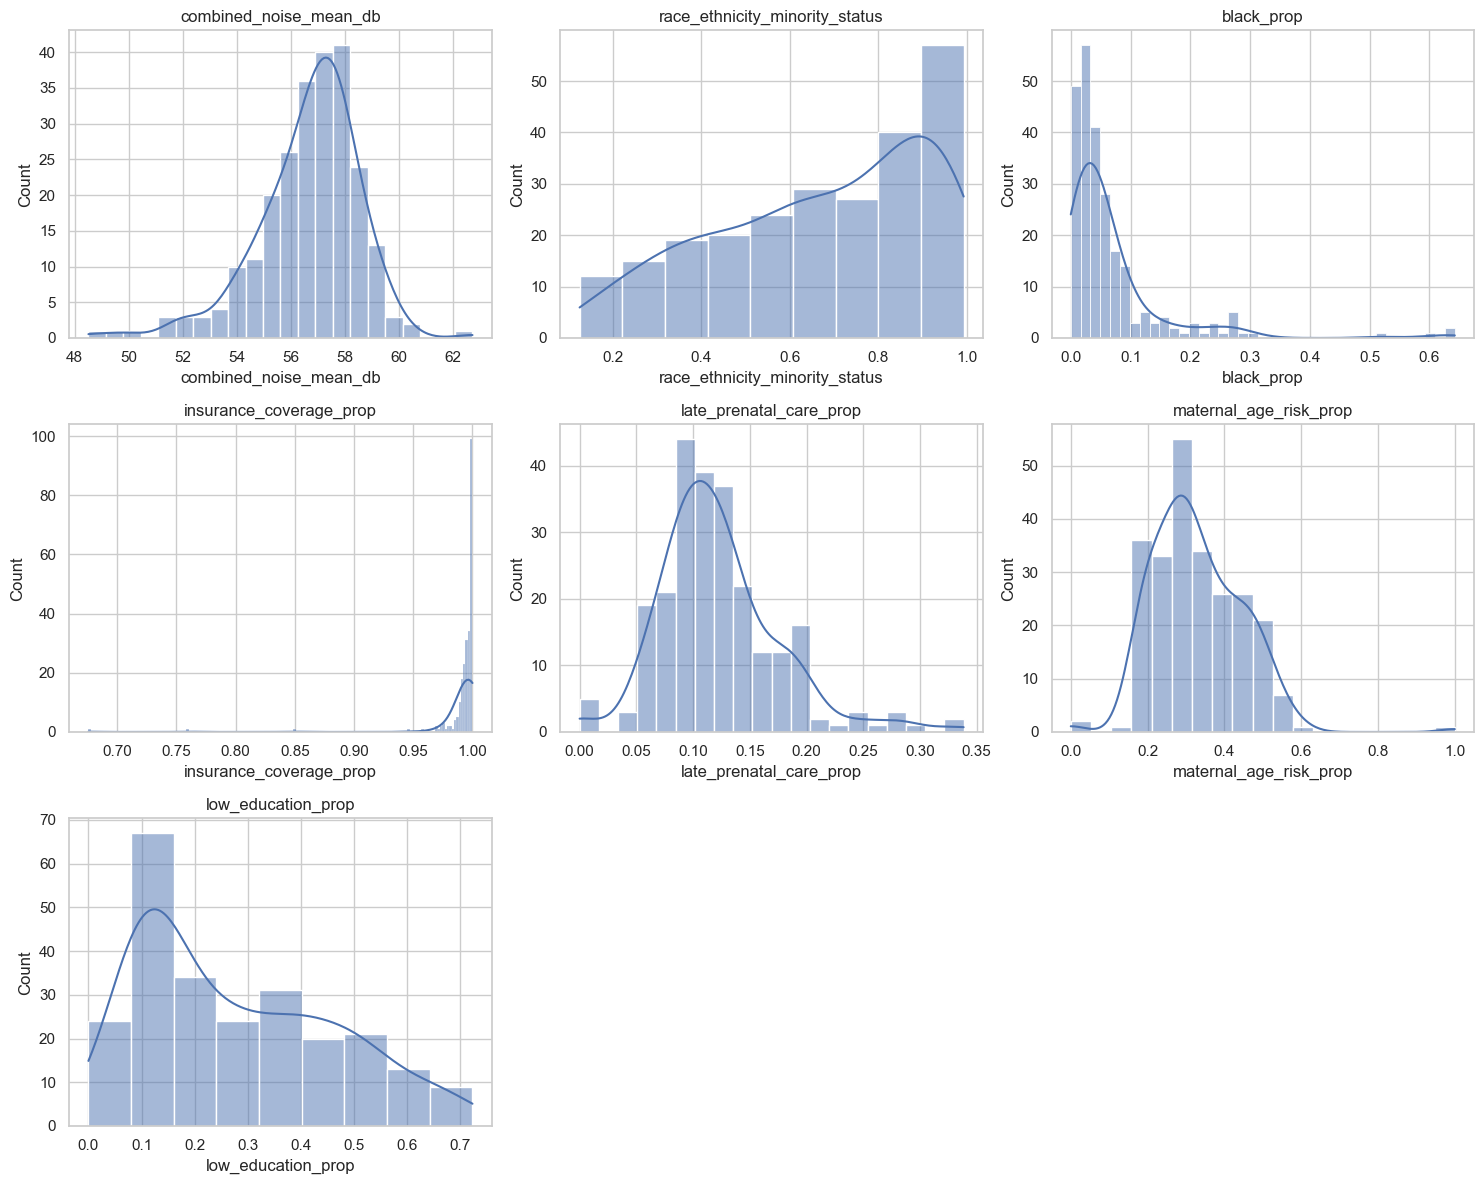

In [18]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(final_features):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots
for j in range(len(final_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


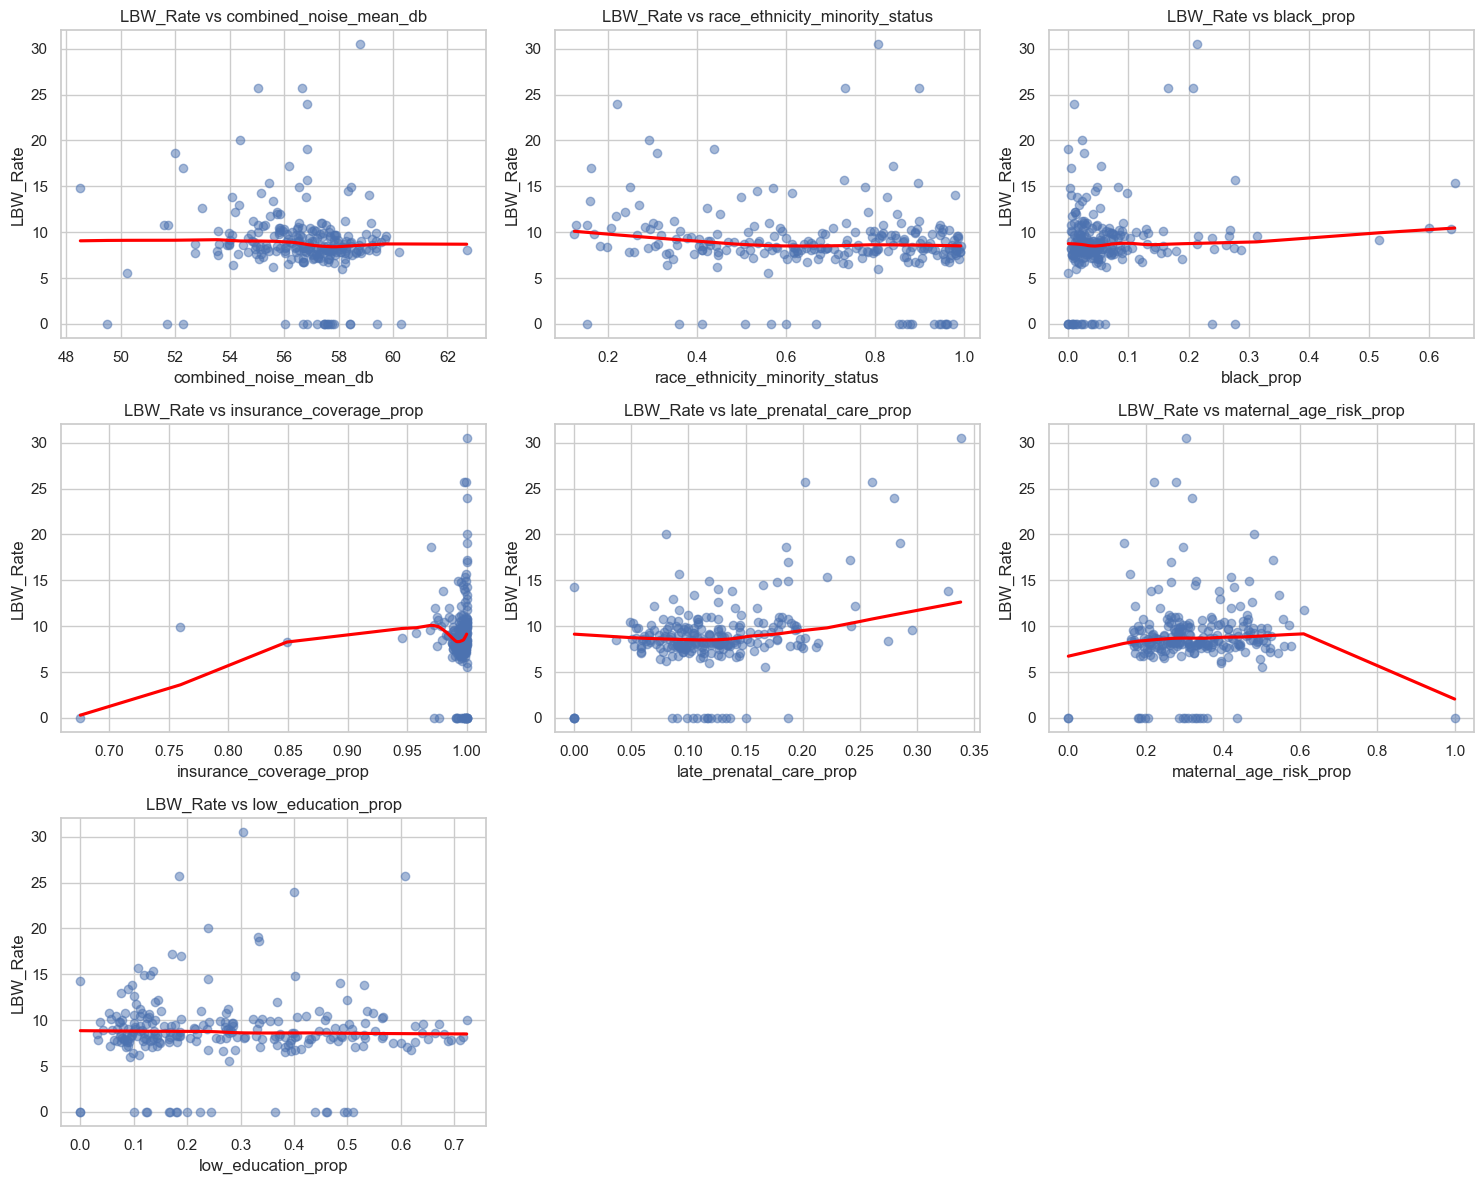

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(final_features):
    sns.regplot(
        x=df[col],
        y=df["LBW_Rate"],
        lowess=True,
        scatter_kws={"alpha": 0.5},
        line_kws={"color": "red"},
        ax=axes[i]
    )
    axes[i].set_title(f"LBW_Rate vs {col}")

# Remove empty subplots
for j in range(len(final_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [21]:
id_vars = ["ZIP_Code_of_Residence"]
outcome_var = "LBW_Rate"
final_features = ["combined_noise_mean_db","race_ethnicity_minority_status","black_prop","insurance_coverage_prop", "late_prenatal_care_prop", "maternal_age_risk_prop","low_education_prop"]

# Final modeling dataset
final_df = df[id_vars+ ["Total_Births_2018_2022"] + ["Total_LBW_Count_2018_2022"] + [outcome_var] + final_features].copy()

final_df.to_csv("final_model_dataset.csv", index=False)
